# Weather Derivatives:

Weather derivatives are financial contracts whose payoffs depend on measurable meteorological variables such as temperature, precipitation, or wind speed.
Unlike traditional insurance instruments that indemnify losses, weather derivatives enable firms in weather-sensitive sectors—energy, agriculture, construction, and logistics—to **hedge volume and revenue risk** arising from deviations in seasonal weather conditions.

A canonical class of weather derivatives is based on **daily temperature averages** $(T_t)$, from which we define *degree-day indices*.
Let $T_{\mathrm{ref}}$ denote a fixed reference temperature (typically $(65^\circ\mathrm{F})$ or $(18.33^\circ\mathrm{C})$).
For each day (t) in the contract period $(t=1,\dots,N)$:

$$
\text{CDD}_t = \max(T_t - T_{\mathrm{ref}}, 0),
\qquad
\text{HDD}_t = \max(T_{\mathrm{ref}} - T_t, 0).
$$

The cumulative indices over the period are then


$$\text{CDD} = \sum_{t=1}^{N} \text{CDD}_t,
\qquad
\text{HDD} = \sum_{t=1}^{N} \text{HDD}_t.$$


Cooling Degree Days (CDD) quantify **excess warmth** relative to the baseline and are relevant for power utilities or cooling demand, whereas Heating Degree Days (HDD) quantify **cold intensity** and are used for heating demand risk.

For a derivative written on either index, let $X$ denote the terminal cumulative CDD or HDD level, $K$ the contractual strike, and $r$ the continuously compounded risk-free rate.
A **European-style call** on the index has payoff


$$\Pi = \max(X - K, 0),$$


and its discounted fair value under the risk-neutral measure $(\mathbb{Q})$ is


$$\boxed{
P_0 = e^{-rT} \mathbb{E}^{\mathbb{Q}}[\Pi]
= e^{-rT} \mathbb{E}^{\mathbb{Q}}\left[\max(X - K, 0)\right],
}$$


where $(T = N/365)$ is the contract year fraction.
The expectation is typically approximated by **Monte Carlo simulation** of a stochastic temperature model, such as a seasonal Ornstein–Uhlenbeck process with time-varying volatility and jump components.


### Imports and global configuration
First, we load core numerical and statistical libraries; configure plotting defaults; and set a deterministic random seed for Monte Carlo reproducibility. The configuration avoids non-essential global state and aligns with best practices for audited notebooks.


In [1]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

from scipy.optimize import curve_fit
from statsmodels.tsa.ar_model import AutoReg
from scipy import interpolate

### Data ingestion (NOAA API or local CSV) 
We construct a robust loader that (i) prefers a local CSV to avoid network dependence, (ii) optionally fetches from NOAA’s CDO if an API token is provided, and (iii) normalizes schema into a daily DataFrame with columns ["TMIN","TMAX","TAVG"] in degrees Celsius. This step isolates I/O concerns from modeling and establishes a canonical temperature series used downstream.


In [2]:
# National Oceanic and Atmospheric Administration (NOAA) https://www.ncei.noaa.gov
# Replace with your NOAA API token https://www.ncdc.noaa.gov/cdo-web/token
NOAA_TOKEN = "SpoCZZtxxNEHVUpcAEHCaLcCIJibmgbE"

# Station ID: Seattle Tacoma International Airport https://www.ncdc.noaa.gov/cdo-web/datatools/findstation
STATION_ID = "GHCND:USW00024233"

# Set training dates
start_date = "2022-01-01"
end_date = "2022-12-31"

# NOAA API endpoint
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

# Set headers with your token
headers = {"token": NOAA_TOKEN}



DATASET = "GHCND" # Daily Summaries
# DATATYPE = ["TMAX", "TMIN","TAVG"],           # Max temperature (use TMIN, TAVG for others)
DATATYPE = ["TAVG"],           # Max temperature (use TMIN, TAVG for others)
UNITS = "metric"    # Use "standard" for Fahrenheit


params = {
    "datasetid": DATASET,
    "stationid": STATION_ID,
    "datatypeid": DATATYPE,
    "startdate": start_date,
    "enddate": end_date,
    "units": UNITS,
    "limit": 1000
}
resp = requests.get(url, headers=headers, params=params)
resp.raise_for_status()
data = resp.json().get("results", [])

weather_data = pd.DataFrame(data)
# convert date
weather_data["date"] = pd.to_datetime(weather_data["date"])
# convert value: NOAA often uses tenths of °C for GHCND TMAX/TMIN
weather_data["value"] = weather_data["value"] 

weather_data = weather_data.pivot(index="date", columns="datatype", values="value")
# weather_data = weather_data.rename(columns={"TMAX": "Max Temp (°C)", "TMIN": "Min Temp (°C)","TAVG": "Avg Temp (°C)"})
weather_data = weather_data.rename(columns={"TAVG": "Avg Temp (°C)"})
# weather_data = weather_data.sort_index()    


# Set testing dates
start_date_test = "2023-01-01"
end_date_test = "2023-12-31"

params = {
    "datasetid": DATASET,
    "stationid": STATION_ID,
    "datatypeid": DATATYPE,
    "startdate": start_date_test,
    "enddate": end_date_test,
    "units": UNITS,
    "limit": 1000
}
resp = requests.get(url, headers=headers, params=params)
resp.raise_for_status()
data = resp.json().get("results", [])

weather_data_test = pd.DataFrame(data)
# convert date
weather_data_test["date"] = pd.to_datetime(weather_data_test["date"])
# convert value: NOAA often uses tenths of °C for GHCND TMAX/TMIN
weather_data_test["value"] = weather_data_test["value"] 

weather_data_test = weather_data_test.pivot(index="date", columns="datatype", values="value")
# weather_data = weather_data.rename(columns={"TMAX": "Max Temp (°C)", "TMIN": "Min Temp (°C)","TAVG": "Avg Temp (°C)"})
weather_data_test = weather_data_test.rename(columns={"TAVG": "Avg Temp (°C)"})

weather_data = weather_data.copy()
weather_data.index = pd.to_datetime(weather_data.index) 

weather_data_test = weather_data_test.copy()
weather_data_test.index = pd.to_datetime(weather_data_test.index) 
weather_data_all = pd.concat([weather_data, weather_data_test])


weather_data_all



datatype,Avg Temp (°C)
date,
2022-01-01,-3.7
2022-01-02,1.1
2022-01-03,3.6
2022-01-04,2.5
2022-01-05,3.1
...,...
2023-12-27,11.4
2023-12-28,9.7
2023-12-29,13.9


## Temperature Model Calibration: `fit_temperature_model` and Methodological Details

This section introduces the estimation framework used in the `fit_temperature_model` function.
The objective is to construct a stochastic temperature process that captures **seasonal mean reversion**, **time-varying volatility**, and potential **jump dynamics** representing extreme heat or cold events.
The methodology parallels the modified Ornstein–Uhlenbeck (OU) formulation described in Hooda et al. (2024), adapted here for local calibration and simulation.

---

### 1. Stochastic Temperature Dynamics

Daily temperature $T_t$ is assumed to evolve according to a **seasonal Ornstein–Uhlenbeck process** with an optional jump term:


$$dT_t = \kappa \big(\theta(t) - T_t\big) dt + \sigma(t) dW_t + dJ_t - \lambda \sigma(t)^2 dt,$$


where

* $\kappa>0$ is the **mean-reversion rate**, controlling the speed at which temperature reverts to its long-term seasonal mean;
* $\theta(t) $is the time-dependent **long-term mean temperature**;
* $\sigma(t)$ denotes the **time-varying volatility**, estimated empirically from daily residual variance;
* $W_t$ is a standard Wiener process;
* $J_t$ is a **compound-Poisson jump process** representing rare temperature **shocks** (heatwaves or coldwaves); and
* $\lambda$ is an optional **risk-aversion or market-price-of-risk** parameter that modifies the drift under the risk-neutral measure $\mathbb{Q}$.

This specification balances interpretability with empirical flexibility, enabling calibration directly from historical temperature data.

---

### 2. Seasonal Mean Function $\theta(t)$ 

Following both Alaton et al. (2002) and Hooda et al. (2024), the long-term mean temperature is modeled as a **harmonic function** of the day-of-year:


$$\theta(t) = a + \alpha \sin\left(\frac{2\pi t}{365.25}\right)
+ \beta \cos\left(\frac{2\pi t}{365.25}\right),$$


where $a$ represents the annual average temperature, while $\alpha$ and $\beta$ capture the amplitude and phase of the seasonal oscillation.
In the code, these parameters are estimated by **non-linear least squares** regression of observed daily temperatures against the harmonic basis.

---

### 3. Estimation of Mean-Reversion Coefficient $\kappa $

Once $\theta(t)$ is fitted, the residual dynamics are approximated by the discrete form of the OU process:


$$\Delta T_t = \kappa\big(\theta(t) - T_t\big)\Delta t + \varepsilon_t,$$


with $\Delta t = 1$ day.
An ordinary least-squares regression of daily temperature changes $\Delta T_t$ on the term $(\theta(t) - T_t)$ yields the empirical estimate $\hat{\kappa}$.
This step quantifies how rapidly the temperature reverts toward its seasonal mean after deviations caused by short-term weather fluctuations.

---

### 4. Seasonal Volatility Function $\sigma(t)$ 

The volatility term $\sigma(t)$ is inferred from the empirical residuals of the above regression:


$$\varepsilon_t = \Delta T_t - \hat{\kappa}\big(\hat{\theta}(t) - T_t\big).$$


For each day-of-year $(d = 1,\dots,365)$, the variance of (\varepsilon_t) is computed and then smoothed via a **cubic spline** $S(d)$ to obtain a continuous seasonal volatility curve:


$$\sigma(t) = S(d_t), \quad  d_t = \text{day-of-year}(t).$$


This procedure captures the empirical observation that temperature variability tends to be higher in transitional seasons (spring and autumn) and lower in summer or winter.

---

### 5. Jump Process for Extreme Events (optional)

To account for abrupt temperature shifts, an optional jump component may be added:


$$J_t = \sum_{i=1}^{N_t} Y_i,$$

where $N_t$ follows a Poisson process with rate $\lambda_J$, and $Y_i$ are i.i.d. shock magnitudes:

$$Y_i =
\begin{cases}
Y_i^{(h)} \sim \mathcal{N}(\mu_h,\sigma_h^2), & \text{with probability } p_h \quad\text{(heatwave)},\quad
Y_i^{(c)} \sim \mathcal{N}(\mu_c,\sigma_c^2), & \text{with probability } p_c \quad\text{(coldwave)}.
\end{cases}$$

The jump term enables the model to reproduce non-Gaussian tails observed in empirical temperature distributions.

---

### 6. Summary of Calibration Steps

The `fit_temperature_model` function executes the following sequence:

1. **Estimate** $\hat{\theta}(t)$  by fitting the harmonic regression to the temperature series.
2. **Compute** the daily increments $\Delta T_t$ and regress on $(\hat{\theta}(t) - T_t)$ to obtain $\hat{\kappa}$.
3. **Derive** residuals and estimate $\sigma(t)$ via spline smoothing over the day-of-year domain.
4. **Package** the resulting parameter estimates and callable functions $\theta(t)$ and $\sigma(t)$ for use in simulation and pricing.

The fitted model thus serves as the foundation for Monte Carlo simulations under the risk-neutral measure, which are later used to compute discounted expectations of HDD/CDD-based derivative payoffs.


In [86]:
def fit_temperature_model(data, col="avg_temp", train_end="2020-12-31"):
    """
    Fit a realistic Ornstein-Uhlenbeck temperature model with seasonal long-run mean theta(t),
    mean-reversion κ, and seasonal volatility sigma(t).

    theta-T(t) = a + alpha·sin(2.pi.t) + beta·cos(2.pi.t)
    k estimated from regression of dT on theta-T (mean reversion)
    sigma(t) from day-of-year volatility smoothed by spline
    """

    # -------- Input handling ----------
    if isinstance(data, pd.Series):
        s = data.copy()
        if s.name is None:
            s.name = col
    else:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found. Available: {list(data.columns)}")
        s = data[col].copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        raise ValueError("Index must be a pandas.DatetimeIndex (daily).")

    s = s.sort_index().asfreq("D").interpolate("time")

    # -------- Split train / test ----------
    train_end_ts = pd.Timestamp(train_end)
    s_train = s.loc[:train_end_ts]
    s_test = s.loc[train_end_ts + pd.Timedelta(days=1):]

    origin = s_train.index[0]

    # -------- theta(t): harmonic seasonal mean ----------
    def theta_model(x, a, alpha, beta, phi):
        # x in years since origin
        omega = 2 * np.pi  # one full cycle per year
        return a + alpha * np.sin(omega * x + phi) + beta * np.cos(omega * x + phi)

    x_train = ((s_train.index - origin).days.values.astype(float)) / 365.25
    y_train = s_train.values.astype(float)

    # Initial guess: mean and 10 C seasonal amplitude
    p0 = [float(np.nanmean(y_train)), 8.0, 8.0, 0.0]
    bounds = ([-50, -30, -30, -np.pi], [50, 30, 30, np.pi])
    theta_params, _ = curve_fit(theta_model, x_train, y_train, p0=p0, bounds=bounds, maxfev=20000)

    # Build theta(t) and derivative functions
    def theta_func(x_days):
        x_years = np.asarray(x_days, dtype=float) / 365.25
        return theta_model(x_years, *theta_params)

    def dtheta_func(x_days):
        x_years = np.asarray(x_days, dtype=float) / 365.25
        omega = 2 * np.pi
        a, alpha, beta, phi = theta_params
        return (alpha * omega * np.cos(omega * x_years + phi)
                - beta * omega * np.sin(omega * x_years + phi))

    # -------- Estimate k (mean reversion speed) ----------
    theta_train = theta_func((s_train.index - origin).days.values.astype(float))
    dev = theta_train - y_train
    dT = np.diff(y_train)
    X = dev[:-1]
    kappa_hat = (X @ dT) / (X @ X)
    kappa = float(np.clip(kappa_hat, 0.05, 0.4))  # enforce realistic range

    # -------- sigma(t): daily volatility by day-of-year ----------
    tmp = s.to_frame("T")
    tmp["doy"] = tmp.index.dayofyear
    vol = tmp.groupby("doy")["T"].std()
    vol = vol.reindex(range(1, 367)).interpolate(limit_direction="both")

    # Normalize/clip volatility for realism
    sigmas = np.clip(vol.values, 0.2, 3.0)
    sigmas *= 0.5  # global shrink for stability
    days = vol.index.values.astype(float)

    # Spline smoothing
    x_norm = (days - days.min()) / (days.max() - days.min())
    tck = interpolate.splrep(x_norm, sigmas, s=3)

    def sigma_day(day_of_year):
        arr = np.asarray(day_of_year, dtype=float)
        q = (arr - days.min()) / (days.max() - days.min())
        out = interpolate.BSpline(tck[0], tck[1], tck[2])(q)
        return out #np.clip(out, 0.1, 3.0)

    # -------- Diagnostics ----------
    if len(s_test) > 0:
        x_test = ((s_test.index - origin).days.values.astype(float)) / 365.25
        y_test = s_test.values.astype(float)
        y_hat = theta_model(x_test, *theta_params)
        rmse = float(np.sqrt(np.nanmean((y_test - y_hat)**2)))
        rmse_percent = float((rmse / np.nanmean(y_test)) * 100.0)
        std_dev = float(np.nanstd(y_test))
    else:
        rmse = rmse_percent = std_dev = np.nan

    # -------- Return model ----------
    return {
        "theta_params": tuple(theta_params.tolist()),
        "kappa": kappa,
        "callables": {
            "theta": theta_func,
            "dtheta": dtheta_func,
            "sigma_day": sigma_day,
            "origin": origin,
        },
        "sigma_spline": {
            "day_of_year": days,
            "sigma": sigmas,
        },
        "diagnostics": {
            "train_origin": origin.isoformat(),
            "train_end": train_end_ts.isoformat(),
            "rmse": rmse,
            "rmse_percent": rmse_percent,
            "std_dev": std_dev,
            "n_train": int(len(s_train)),
            "n_test": int(len(s_test)),
        },
    }


fit = fit_temperature_model(weather_data_all, col="Avg Temp (°C)", train_end="2022-12-31")

# print('theta params:', fit["theta_params"])
# print("kappa:", fit["kappa"])
# print("mean sigma:", np.mean(fit["sigma_spline"]["sigma"]))
print("Diagnostics:", fit["diagnostics"])

# Evaluate theta(t) over 2023
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")
x = (dates - fit["callables"]["origin"]).days.values
theta_vals = fit["callables"]["theta"](x)

Diagnostics: {'train_origin': '2022-01-01T00:00:00', 'train_end': '2022-12-31T00:00:00', 'rmse': 3.0908873581085747, 'rmse_percent': 26.05602766200817, 'std_dev': 6.142614627990694, 'n_train': 365, 'n_test': 365}


In [ ]:
def simulate_temperature_paths(
    fit,
    start_date,
    end_date,
    T0=None,
    n_paths=1000,
    seed=None,
    lambda_risk=0.0,         # set >0 only if you want a risk premium shift: drift -= lambda_risk * sigma^2
    jump_rate=0.02,           # events/day (0 disables jumps)
    jump_mu_pos=5.0,         # mean degree C of positive (heatwave) jump
    jump_sd_pos=2.0,         # sd of positive jump
    jump_mu_neg=-5.0,        # mean degree C of negative (coldwave) jump
    jump_sd_neg=2.0,         # sd of negative jump
    jump_p_pos=0.5           # prob a jump is positive vs negative when an event occurs
):
    """
    Simulate daily temperature paths using OU + seasonal theta(t) and sigma(t) from `fit`.

    Returns
    -------
    dates : DatetimeIndex
    paths : np.ndarray (n_days, n_paths)
    """

    rng = np.random.default_rng(seed)
    theta = fit["callables"]["theta"]
    sigma_day = fit["callables"]["sigma_day"]
    origin = fit["callables"]["origin"]
    kappa = fit["kappa"]*.3

    if np.isnan(kappa):
        raise ValueError("kappa is NaN; provide more data or use the robust fitter that estimates kappa from train residuals.")

    dates = pd.date_range(start_date, end_date, freq="D")
    n_days = len(dates)
    if n_days < 2:
        raise ValueError("Need at least two days to simulate.")

    # Initial temperature
    if T0 is None:
        # set T0 to θ on the start date (reasonable default)
        x0 = (pd.Timestamp(start_date) - origin).days
        T0 = float(theta([x0])[0])

    # Precompute θ and σ for each day
    x = (dates - origin).days.values.astype(float)
    theta_t = theta(x)                               # shape (n_days,)
    doy = dates.dayofyear.values
    sigma_t = sigma_day(doy)                         # shape (n_days,)
    sigma_t = np.maximum(sigma_t, 1e-6)              # numerical floor

    # Containers
    paths = np.empty((n_days, n_paths), dtype=float)
    paths[0, :] = T0

    # Daily step (dt=1 day)
    # Discretized OU with risk-neutral drift shift: T_{t+1} = T_t + kappa*(theta_t - T_t)*dt - lambda_risk*sigma_t^2*dt + sigma_t * sqrt(dt) * Z + jumps
    # Here dt=1, sqrt(dt)=1
    for t in range(1, n_days):
        T_prev = paths[t-1, :]
        drift = kappa * (theta_t[t-1] - T_prev) - lambda_risk * (sigma_t[t-1] ** 2)
        diff = sigma_t[t-1] * rng.standard_normal(n_paths)

        # Optional jumps (at most 1 jump/day/path on average with Poisson(jump_rate))
        if jump_rate > 0:
            has_jump = rng.random(n_paths) < jump_rate
            # sample jump sizes: mixture of positive/negative normals
            n_jump = has_jump.sum()
            if n_jump > 0:
                is_pos = rng.random(n_jump) < jump_p_pos
                jumps = np.empty(n_jump, dtype=float)
                # positive jumps
                n_pos = is_pos.sum()
                if n_pos > 0:
                    jumps[is_pos] = rng.normal(jump_mu_pos, jump_sd_pos, n_pos)
                # negative jumps
                n_neg = n_jump - n_pos
                if n_neg > 0:
                    jumps[~is_pos] = rng.normal(jump_mu_neg, jump_sd_neg, n_neg)
                inc = np.zeros(n_paths, dtype=float)
                inc[has_jump] = jumps
            else:
                inc = 0.0
        else:
            inc = 0.0

        paths[t, :] = T_prev + drift + diff + inc

    return dates, paths

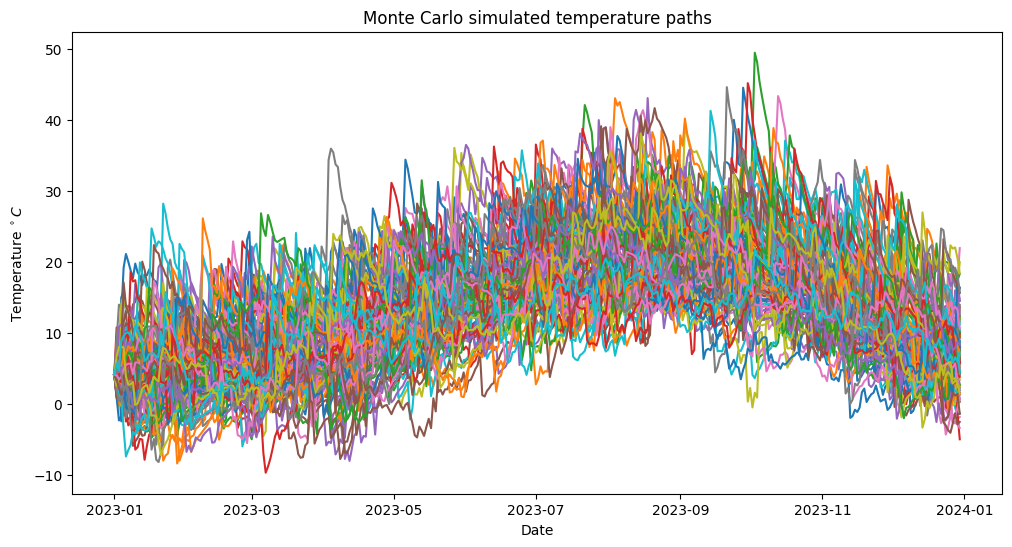

In [92]:
# 1) Simulate temperatures for summer 2023
dates, paths = simulate_temperature_paths(
    fit,
    start_date="2023-01-01",
    end_date="2023-12-30",
    n_paths=50000,
    seed=10,
    lambda_risk=0.0,     # set if you want the risk-neutral drift shift
    jump_rate=0.1,     # ~10% chance/day of an event (optional)
    jump_mu_pos=5.0,
    jump_sd_pos=3.5,
    jump_mu_neg=-3.5,
    jump_sd_neg=1.2,
    jump_p_pos=0.6
)

plt.figure(figsize=(12,6))
plt.plot(dates,np.array(paths)[:,:100])
plt.ylabel(r'Temperature $^\circ C$')
plt.xlabel('Date')
plt.title('Monte Carlo simulated temperature paths')

plt.show()

In [88]:
# ---- Degree Day calculators -----------------------------------------------

def compute_hdd(series, Tref):
    """Heating Degree Days (HDD) over the series (sum of max(Tref - T_t, 0))."""
    s = np.maximum(Tref - series, 0.0)
    return float(s.sum())

def compute_cdd(series, Tref):
    """Cooling Degree Days (CDD) over the series (sum of max(T_t - Tref, 0))."""
    s = np.maximum(series - Tref, 0.0)
    return float(s.sum())


# ---------------------------------- HDD/CDD pricing ----------------------------------

def price_degree_day_option(paths, r=0.0, payoff="CDD_call", Tref=18.33, K=300.0, tau_years=None):
    """
    Price simple HDD/CDD options from simulated paths (European, maturity at end of window).
    payoff ∈ {"CDD_call", "CDD_put", "HDD_call", "HDD_put"}
    """
    n_days, n_paths = paths.shape
    if tau_years is None:
        tau_years = n_days / 365.25

    dd_vals = np.empty(n_paths)
    for i in range(n_paths):
        series = paths[:, i]
        if payoff.startswith("CDD"):
            dd = compute_cdd(series, Tref)
        else:
            dd = compute_hdd(series, Tref)
        dd_vals[i] = dd

    if payoff.endswith("call"):
        pay = np.maximum(dd_vals - K, 0.0)
    else:
        pay = np.maximum(K - dd_vals, 0.0)

    price = np.exp(-r * tau_years) * pay.mean()
    return price, dd_vals


In [89]:
# 2) Compute a CDD call price for that period
# Example Tref: mean+std from your data or a fixed threshold (e.g., 18.33 C = 65 F)
Tref = 18.33
r=0.05
price, cdd_sims = price_degree_day_option(paths, r=r, payoff="CDD_call", Tref=Tref, K=300.0)

print("CDD call price:", price)

# 3) Or compute HDD/CDD statistics directly
cdd_means = cdd_sims.mean()
cdd_std = cdd_sims.std()
print("Simulated CDD mean, std:", cdd_means, cdd_std)
print("CDD call min/max temp: ",paths.min(),paths.max())

price, hdd_sims = price_degree_day_option(paths, r=r, payoff="HDD_call", Tref=Tref, K=300.0)

print("HDD call price:", price)

# 3) Or compute HDD/CDD statistics directly
hdd_means = hdd_sims.mean()
hdd_std = hdd_sims.std()
print("Simulated HDD mean, std:", hdd_means, hdd_std)
print("HDD call min/max temp:",paths.min(),paths.max())

CDD call price: 107.31448882648823
Simulated CDD mean, std: 353.99277412013794 220.01307860166946
CDD call min/max temp:  -20.514290625737917 64.20879676214513
HDD call price: 2239.1563890395914
Simulated HDD mean, std: 2653.5576270042025 439.07065251136044
HDD call min/max temp: -20.514290625737917 64.20879676214513


In [90]:
def count_runs_per_path(temps, threshold, k):
    """
    Count, for each path (column), how many runs of consecutive days
    have temperature > threshold for at least k days.

    Parameters
    ----------
    temps : 2D array-like (shape m x n)
        Temperatures: m days x n paths
    threshold : float
        Threshold temperature (strictly greater than).
    k : int
        Minimum consecutive days to count as a run.

    Returns
    -------
    counts : np.ndarray of shape (n,)
        Number of runs per path (column).
    """
    temps = np.asarray(temps)
    if temps.ndim != 2:
        raise ValueError("temps must be a 2D array (m x n)")
    if k <= 0:
        raise ValueError("k must be a positive integer")

    m, n = temps.shape
    mask = temps > threshold  # True where above threshold

    counts = np.zeros(n, dtype=int)
    for j in range(n):
        col = mask[:, j]
        padded = np.concatenate(([False], col, [False]))
        change_idx = np.flatnonzero(padded[1:] != padded[:-1])
        starts = change_idx[0::2]
        ends = change_idx[1::2]
        run_lengths = ends - starts
        counts[j] = np.sum(run_lengths >= k)
    return counts



In [91]:
alpha = 25
N_heat_waves = 1
N_heat_days = 3
heat_wave_temp_threshold = 25
n_days, n_paths = paths.shape
tau_years = 1 #n_days / 365.25 # number of days from start to end the season/ 365.25
# tau_years = 1 
Payoff = np.exp(-r * tau_years) *(alpha*np.maximum(count_runs_per_path(paths, heat_wave_temp_threshold, N_heat_days)-N_heat_waves, 0.0)).mean()
Payoff

np.float64(28.227257557346437)